# Lineitem Thread Count Performance Comparison
Comparing baseline (without OVC) vs OVC-enabled sort performance

In [164]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib for better-looking plots
plt.style.use("custom_plt_sytle.mplstyle")

In [165]:
def parse_log_file(filename):
    """Parse the benchmark log file and extract performance metrics from summary table"""
    data = []

    with open(filename, 'r') as f:
        lines = f.readlines()

    # Find the summary table and parse it
    for line in lines:
        # Look for table rows with Thread_X pattern
        match = re.match(r'Thread_(\d+)\s+(\d+)\s+([\d.]+)\s+GB\s+([\d.]+)\s+(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', line)
        if match:
            threads = int(match.group(1))
            total_time = float(match.group(8))
            rungen_time = float(match.group(9))
            merge_time = float(match.group(10))
            throughput = float(match.group(12))
            read_mb = float(match.group(13))
            write_mb = float(match.group(14))

            total_io_gb = (read_mb + write_mb) / 1024.0

            data.append({
                'threads': threads,
                'total_time': total_time,
                'rungen_time': rungen_time,
                'merge_time': merge_time,
                'throughput': throughput,
                'total_io_gb': total_io_gb,
                'per_thread_throughput': throughput / threads,
                'io_bandwidth_gbps': total_io_gb / total_time
            })

    return sorted(data, key=lambda x: x['threads'])

def parse_detailed_io(filename):
    """Parse detailed I/O statistics from the log file"""
    data = []

    with open(filename, 'r') as f:
        lines = f.readlines()

    # Find the detailed I/O statistics table
    for line in lines:
        # Look for detailed I/O rows with Thread_X pattern
        match = re.match(r'Thread_(\d+)\s+(\d+)\s+([\d.]+)\s+GB\s+([\d]+)\s+/\s+([\d.]+)\s+([\d]+)\s+/\s+([\d.]+)\s+([\d]+)\s+/\s+([\d.]+)\s+([\d]+)\s+/\s+([\d.]+)', line)
        if match:
            threads = int(match.group(1))
            rungen_read_mb = float(match.group(5))
            rungen_write_mb = float(match.group(7))
            merge_read_mb = float(match.group(9))
            merge_write_mb = float(match.group(11))

            data.append({
                'threads': threads,
                'rungen_read_gb': rungen_read_mb / 1024.0,
                'rungen_write_gb': rungen_write_mb / 1024.0,
                'merge_read_gb': merge_read_mb / 1024.0,
                'merge_write_gb': merge_write_mb / 1024.0,
                'rungen_total_io_gb': (rungen_read_mb + rungen_write_mb) / 1024.0,
                'merge_total_io_gb': (merge_read_mb + merge_write_mb) / 1024.0
            })

    return sorted(data, key=lambda x: x['threads'])

In [166]:
def parse_partition_imbalance(filename):
    """Parse partition imbalance data from the log file"""
    data = []
    
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i]
        
        # Look for "Partition imbalance:" header
        if "Partition imbalance:" in line:
            # Extract partition count from next line
            if i + 1 < len(lines):
                partitions_match = re.search(r'Partitions:\s+(\d+)', lines[i + 1])
                if partitions_match:
                    num_partitions = int(partitions_match.group(1))
                    
                    # Skip to avg per partition line
                    avg_match = None
                    max_match = None
                    
                    # Look ahead for avg and max lines
                    for j in range(i + 2, min(i + 7, len(lines))):
                        if "Avg per partition:" in lines[j]:
                            avg_match = re.search(r'Avg per partition:\s+([\d]+)', lines[j])
                        if "Max entries:" in lines[j]:
                            max_match = re.search(r'Max entries:\s+([\d]+)', lines[j])
                    
                    if avg_match and max_match:
                        avg_entries = int(avg_match.group(1))
                        max_entries = int(max_match.group(1))
                        
                        data.append({
                            'threads': num_partitions,
                            'avg_partition_size': avg_entries,
                            'max_partition_size': max_entries,
                            'imbalance_ratio': max_entries / avg_entries
                        })
        
        i += 1
    
    # Group by thread count and calculate average across all runs
    from collections import defaultdict
    thread_data = defaultdict(list)
    for item in data:
        thread_data[item['threads']].append(item)
    
    # Calculate averages for each thread count
    averaged_data = []
    for threads, items in thread_data.items():
        avg_avg_size = sum(d['avg_partition_size'] for d in items) / len(items)
        avg_max_size = sum(d['max_partition_size'] for d in items) / len(items)
        avg_imbalance = sum(d['imbalance_ratio'] for d in items) / len(items)
        
        averaged_data.append({
            'threads': threads,
            'avg_partition_size': avg_avg_size,
            'max_partition_size': avg_max_size,
            'imbalance_ratio': avg_imbalance,
            'num_runs': len(items)
        })
    
    return sorted(averaged_data, key=lambda x: x['threads'])

In [167]:
# Parse both log files
baseline_data = parse_log_file('lineitem_thread_count_2025-10-04_23-15-06_baseline.log')
ovc_data = parse_log_file('lineitem_thread_count_2025-10-04_23-15-06_ovc.log')

# Parse detailed I/O data
baseline_io_data = parse_detailed_io('lineitem_thread_count_2025-10-04_23-15-06_baseline.log')
ovc_io_data = parse_detailed_io('lineitem_thread_count_2025-10-04_23-15-06_ovc.log')

print(f"Baseline data points: {len(baseline_data)}")
print(f"OVC data points: {len(ovc_data)}")
print(f"Baseline I/O data points: {len(baseline_io_data)}")
print(f"OVC I/O data points: {len(ovc_io_data)}")

Baseline data points: 7
OVC data points: 7
Baseline I/O data points: 7
OVC I/O data points: 7


In [168]:
# Parse partition imbalance data
baseline_partition_data = parse_partition_imbalance('lineitem_thread_count_2025-10-04_23-15-06_baseline.log')
ovc_partition_data = parse_partition_imbalance('lineitem_thread_count_2025-10-04_23-15-06_ovc.log')

print(f"Baseline partition data points: {len(baseline_partition_data)}")
print(f"OVC partition data points: {len(ovc_partition_data)}")
print("\nBaseline partition data (averaged across runs):")
for item in baseline_partition_data:
    print(f"  {item['threads']:2d} threads ({item['num_runs']} runs): avg={item['avg_partition_size']:,.0f}, max={item['max_partition_size']:,.0f}, ratio={item['imbalance_ratio']:.4f}")
print("\nOVC partition data (averaged across runs):")
for item in ovc_partition_data:
    print(f"  {item['threads']:2d} threads ({item['num_runs']} runs): avg={item['avg_partition_size']:,.0f}, max={item['max_partition_size']:,.0f}, ratio={item['imbalance_ratio']:.4f}")

Baseline partition data points: 6
OVC partition data points: 6

Baseline partition data (averaged across runs):
   2 threads (1 runs): avg=1,500,014,121, max=1,516,494,203, ratio=1.0110
   4 threads (1 runs): avg=750,007,060, max=774,832,816, ratio=1.0331
   8 threads (3 runs): avg=375,003,530, max=388,911,081, ratio=1.0371
  16 threads (3 runs): avg=187,501,765, max=201,832,744, ratio=1.0764
  24 threads (3 runs): avg=125,001,177, max=137,393,842, ratio=1.0991
  32 threads (3 runs): avg=93,750,883, max=116,687,218, ratio=1.2447

OVC partition data (averaged across runs):
   2 threads (1 runs): avg=1,500,014,121, max=1,509,238,243, ratio=1.0061
   4 threads (1 runs): avg=750,007,060, max=776,276,480, ratio=1.0350
   8 threads (3 runs): avg=375,003,530, max=392,116,586, ratio=1.0456
  16 threads (3 runs): avg=187,501,765, max=205,250,535, ratio=1.0947
  24 threads (3 runs): avg=125,001,177, max=140,585,633, ratio=1.1247
  32 threads (3 runs): avg=93,750,883, max=114,845,389, ratio=1.225

In [169]:
# Extract data for plotting
baseline_threads = [d['threads'] for d in baseline_data]
baseline_throughput = [d['throughput'] for d in baseline_data]
baseline_time = [d['total_time'] for d in baseline_data]
baseline_io = [d['total_io_gb'] for d in baseline_data]
baseline_per_thread = [d['per_thread_throughput'] for d in baseline_data]
baseline_bandwidth = [d['io_bandwidth_gbps'] for d in baseline_data]

ovc_threads = [d['threads'] for d in ovc_data]
ovc_throughput = [d['throughput'] for d in ovc_data]
ovc_time = [d['total_time'] for d in ovc_data]
ovc_io = [d['total_io_gb'] for d in ovc_data]
ovc_per_thread = [d['per_thread_throughput'] for d in ovc_data]
ovc_bandwidth = [d['io_bandwidth_gbps'] for d in ovc_data]

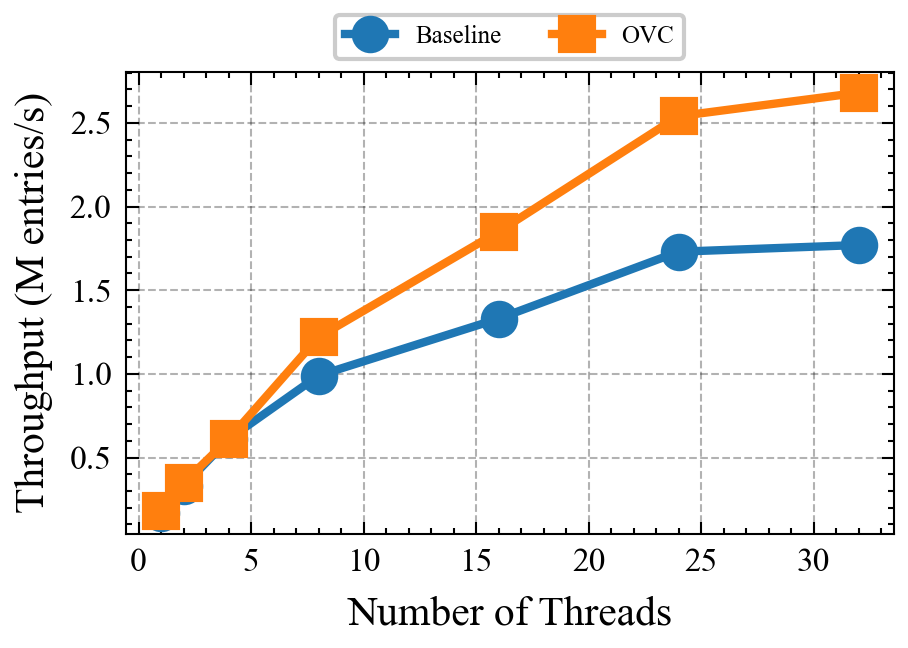

In [170]:
# Plot 1: Throughput vs Threads
fig, ax = plt.subplots()
ax.plot(baseline_threads, baseline_throughput, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax.plot(ovc_threads, ovc_throughput, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Throughput (M entries/s)')
# ax.set_title('Throughput vs Thread Count')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
ax.grid(True, alpha=0.3)
# ax.set_xscale('log', base=2)
# plt.tight_layout()
plt.savefig('thread_count_throughput.png', dpi=300)
plt.savefig('thread_count_throughput.svg')
plt.show()

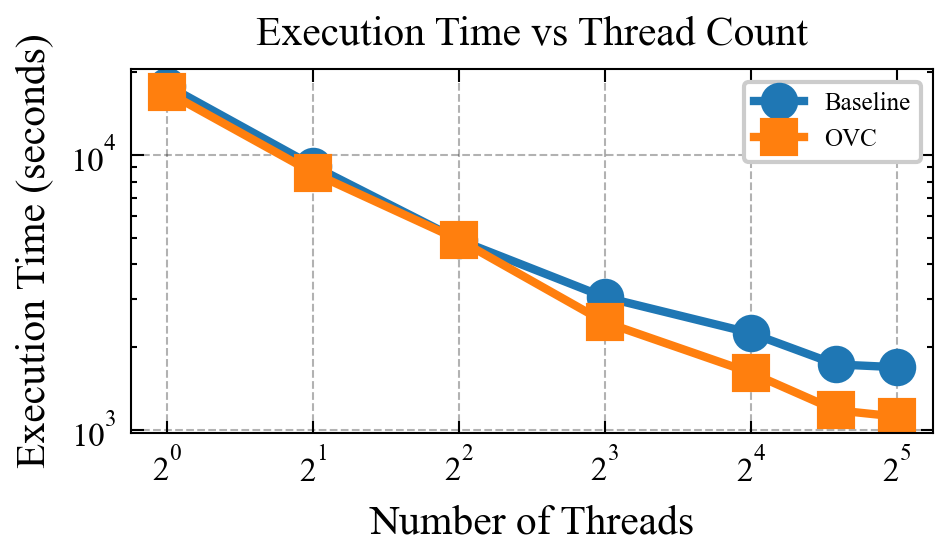

In [171]:
# Plot 2: Execution Time vs Threads
fig, ax = plt.subplots()
ax.plot(baseline_threads, baseline_time, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax.plot(ovc_threads, ovc_time, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Execution Time vs Thread Count')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)
ax.set_yscale('log')
plt.tight_layout()
# plt.savefig('thread_count_time.png', dpi=300, bbox_inches='tight')
# plt.savefig('thread_count_time.svg', bbox_inches='tight')
plt.show()

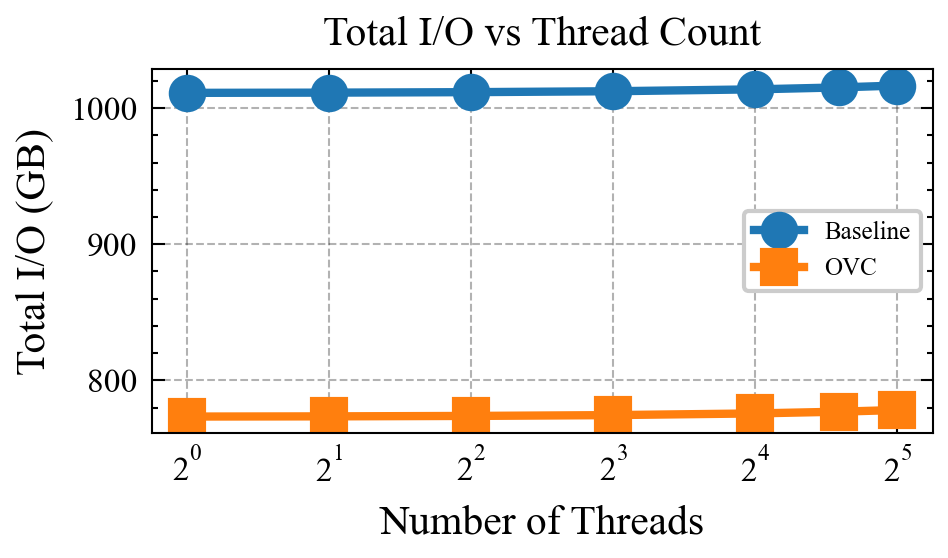

In [172]:
# Plot 3: Total I/O vs Threads
fig, ax = plt.subplots()
ax.plot(baseline_threads, baseline_io, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax.plot(ovc_threads, ovc_io, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Total I/O (GB)')
ax.set_title('Total I/O vs Thread Count')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)
plt.tight_layout()
# plt.savefig('thread_count_io.png', dpi=300, bbox_inches='tight')
# plt.savefig('thread_count_io.svg', bbox_inches='tight')
plt.show()

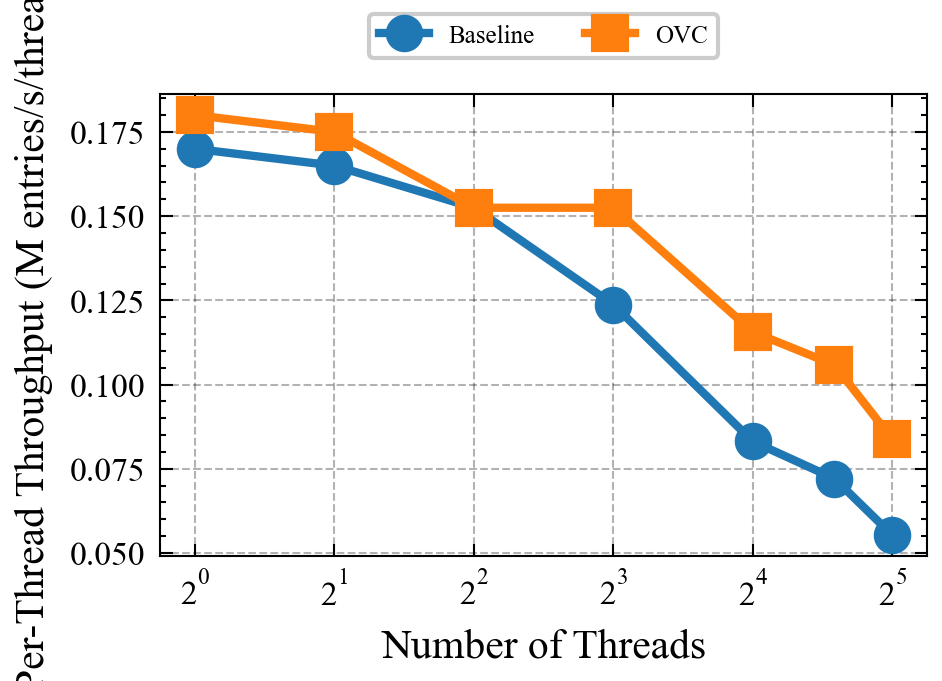

In [173]:
# Plot 4: Per-Thread Throughput vs Threads
fig, ax = plt.subplots()
ax.plot(baseline_threads, baseline_per_thread, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax.plot(ovc_threads, ovc_per_thread, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Per-Thread Throughput (M entries/s/thread)')
# ax.set_title('Per-Thread Throughput vs Thread Count')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)
# plt.tight_layout()
# plt.savefig('thread_count_per_thread_throughput.png', dpi=300, bbox_inches='tight')
# plt.savefig('thread_count_per_thread_throughput.svg', bbox_inches='tight')
plt.show()

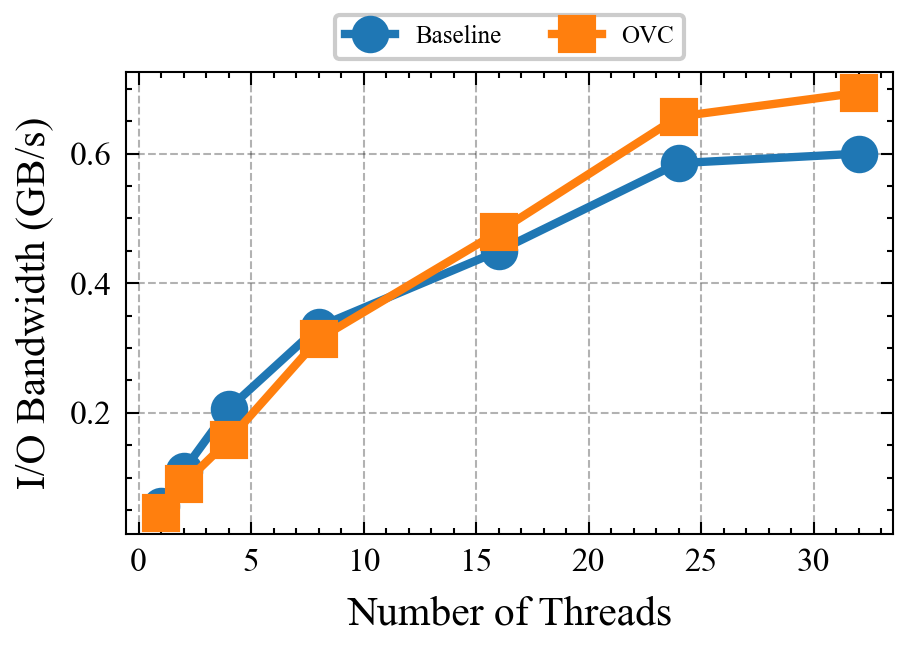

In [174]:
# Plot 5: I/O Bandwidth vs Threads
fig, ax = plt.subplots()
ax.plot(baseline_threads, baseline_bandwidth, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax.plot(ovc_threads, ovc_bandwidth, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
ax.set_xlabel('Number of Threads')
ax.set_ylabel('I/O Bandwidth (GB/s)')
# ax.set_title('I/O Bandwidth vs Thread Count')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
ax.grid(True, alpha=0.3)
# ax.set_xscale('log', base=2)
# plt.tight_layout()
plt.savefig('thread_count_io_bandwidth_overall.png', dpi=300)
plt.savefig('thread_count_io_bandwidth_overall.svg')
plt.show()

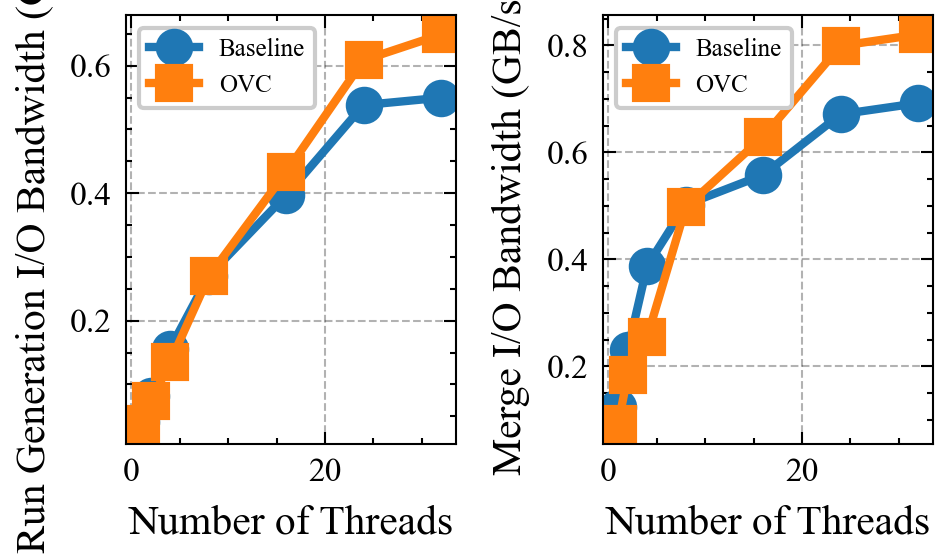

In [175]:
# Plot 5b: I/O Bandwidth vs Threads (separated by phase)
fig, (ax1, ax2) = plt.subplots(1, 2)

# Extract phase-specific data
baseline_threads_io = [d['threads'] for d in baseline_io_data]
baseline_rungen_io = [d['rungen_total_io_gb'] for d in baseline_io_data]
baseline_merge_io = [d['merge_total_io_gb'] for d in baseline_io_data]

ovc_threads_io = [d['threads'] for d in ovc_io_data]
ovc_rungen_io = [d['rungen_total_io_gb'] for d in ovc_io_data]
ovc_merge_io = [d['merge_total_io_gb'] for d in ovc_io_data]

# Get corresponding times for bandwidth calculation
baseline_rungen_time_dict = {d['threads']: d['rungen_time'] for d in baseline_data}
baseline_merge_time_dict = {d['threads']: d['merge_time'] for d in baseline_data}
ovc_rungen_time_dict = {d['threads']: d['rungen_time'] for d in ovc_data}
ovc_merge_time_dict = {d['threads']: d['merge_time'] for d in ovc_data}

# Calculate bandwidth for each phase using actual times
baseline_rungen_bw = [io / baseline_rungen_time_dict[t] for t, io in zip(baseline_threads_io, baseline_rungen_io)]
baseline_merge_bw = [io / baseline_merge_time_dict[t] for t, io in zip(baseline_threads_io, baseline_merge_io)]

ovc_rungen_bw = [io / ovc_rungen_time_dict[t] for t, io in zip(ovc_threads_io, ovc_rungen_io)]
ovc_merge_bw = [io / ovc_merge_time_dict[t] for t, io in zip(ovc_threads_io, ovc_merge_io)]

# Plot run generation I/O bandwidth
ax1.plot(baseline_threads_io, baseline_rungen_bw, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax1.plot(ovc_threads_io, ovc_rungen_bw, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
ax1.set_xlabel('Number of Threads')
ax1.set_ylabel('Run Generation I/O Bandwidth (GB/s)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot merge I/O bandwidth
ax2.plot(baseline_threads_io, baseline_merge_bw, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax2.plot(ovc_threads_io, ovc_merge_bw, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
ax2.set_xlabel('Number of Threads')
ax2.set_ylabel('Merge I/O Bandwidth (GB/s)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('thread_count_io_bandwidth_separated.png', dpi=300, bbox_inches='tight')
# plt.savefig('thread_count_io_bandwidth_separated.svg', bbox_inches='tight')
plt.show()

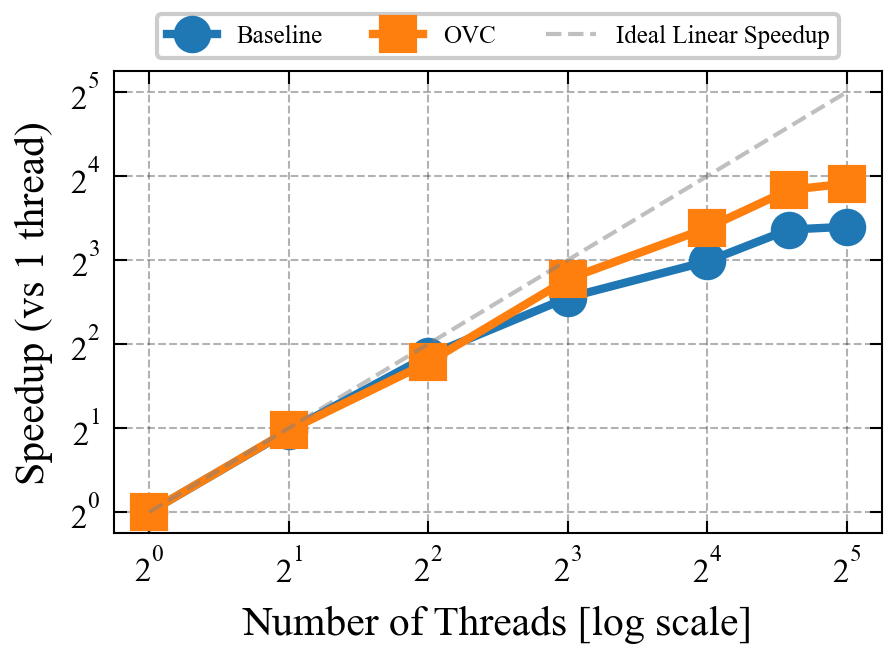

In [176]:
# Plot 6: Speedup comparison (relative to 1 thread baseline)
fig, ax = plt.subplots()
baseline_speedup = [baseline_time[0] / t for t in baseline_time]
ovc_speedup = [ovc_time[0] / t for t in ovc_time]
ax.plot(baseline_threads, baseline_speedup, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax.plot(ovc_threads, ovc_speedup, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
# Add ideal linear speedup line
ax.plot(baseline_threads, baseline_threads, '--', color='gray', alpha=0.5, label='Ideal Linear Speedup')
ax.set_xlabel('Number of Threads [log scale]')
ax.set_ylabel('Speedup (vs 1 thread)')
# ax.set_title('Speedup vs Thread Count')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
# plt.tight_layout()
plt.savefig('thread_count_speedup.png', dpi=300, bbox_inches='tight')
plt.savefig('thread_count_speedup.svg', bbox_inches='tight')
plt.show()

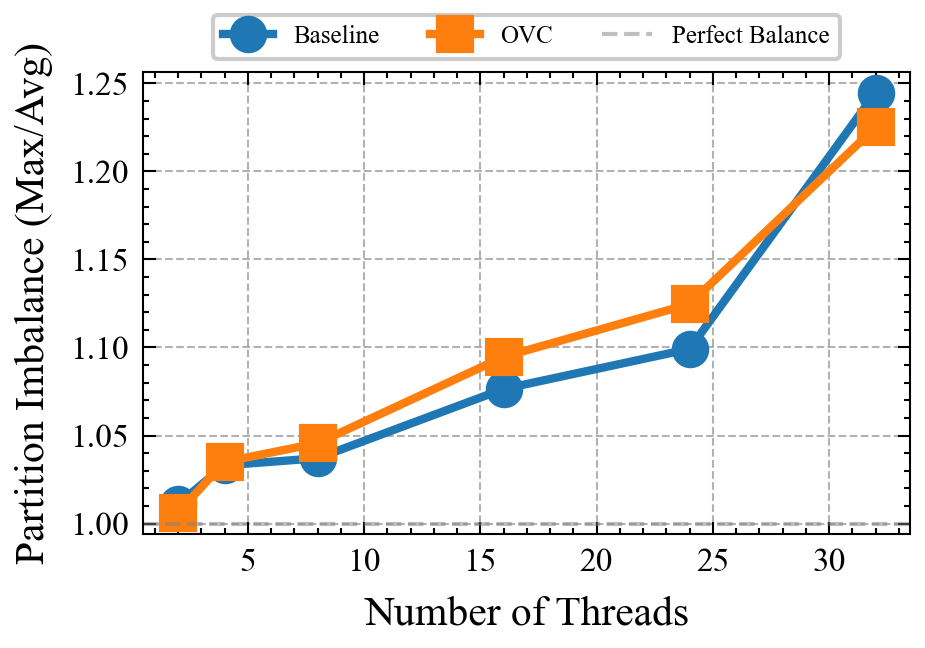

In [177]:
# Extract data for plotting
baseline_part_threads = [d['threads'] for d in baseline_partition_data]
baseline_part_avg = [d['avg_partition_size'] / 1e6 for d in baseline_partition_data]  # Convert to millions
baseline_part_max = [d['max_partition_size'] / 1e6 for d in baseline_partition_data]  # Convert to millions

ovc_part_threads = [d['threads'] for d in ovc_partition_data]
ovc_part_avg = [d['avg_partition_size'] / 1e6 for d in ovc_partition_data]  # Convert to millions
ovc_part_max = [d['max_partition_size'] / 1e6 for d in ovc_partition_data]  # Convert to millions

# Also plot the imbalance ratio
fig, ax = plt.subplots()
baseline_imbalance_ratio = [d['imbalance_ratio'] for d in baseline_partition_data]
ovc_imbalance_ratio = [d['imbalance_ratio'] for d in ovc_partition_data]

ax.plot(baseline_part_threads, baseline_imbalance_ratio, 'o-', label='Baseline', linewidth=2, markersize=8, color='#1f77b4')
ax.plot(ovc_part_threads, ovc_imbalance_ratio, 's-', label='OVC', linewidth=2, markersize=8, color='#ff7f0e')
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Perfect Balance')
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Partition Imbalance (Max/Avg)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.grid(True, alpha=0.3)
# ax.set_xscale('log', base=2)
# plt.tight_layout()
plt.savefig('thread_count_partition_imbalance.png', dpi=300, bbox_inches='tight')
plt.savefig('thread_count_partition_imbalance.svg', bbox_inches='tight')
plt.show()

In [178]:
# Print summary statistics
print("="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(f"\nBaseline (no OVC):")
print(f"  Best throughput: {max(baseline_throughput):.2f} M entries/s at {baseline_threads[baseline_throughput.index(max(baseline_throughput))]} threads")
print(f"  Fastest time: {min(baseline_time):.2f} s at {baseline_threads[baseline_time.index(min(baseline_time))]} threads")
print(f"  Total I/O range: {min(baseline_io):.2f} - {max(baseline_io):.2f} GB")
print(f"  Max I/O bandwidth: {max(baseline_bandwidth):.3f} GB/s at {baseline_threads[baseline_bandwidth.index(max(baseline_bandwidth))]} threads")

print(f"\nOVC Enabled:")
print(f"  Best throughput: {max(ovc_throughput):.2f} M entries/s at {ovc_threads[ovc_throughput.index(max(ovc_throughput))]} threads")
print(f"  Fastest time: {min(ovc_time):.2f} s at {ovc_threads[ovc_time.index(min(ovc_time))]} threads")
print(f"  Total I/O range: {min(ovc_io):.2f} - {max(ovc_io):.2f} GB")
print(f"  Max I/O bandwidth: {max(ovc_bandwidth):.3f} GB/s at {ovc_threads[ovc_bandwidth.index(max(ovc_bandwidth))]} threads")

print(f"\nI/O Savings with OVC:")
for i in range(len(baseline_threads)):
    if baseline_threads[i] == ovc_threads[i]:
        io_reduction = (1 - ovc_io[i] / baseline_io[i]) * 100
        time_improvement = (1 - ovc_time[i] / baseline_time[i]) * 100
        print(f"  {baseline_threads[i]:2d} threads: I/O reduced by {io_reduction:5.2f}%, Time improved by {time_improvement:5.2f}%")
        
print("\n" + "="*80)

PERFORMANCE SUMMARY

Baseline (no OVC):
  Best throughput: 1.77 M entries/s at 32 threads
  Fastest time: 1694.20 s at 32 threads
  Total I/O range: 1011.24 - 1016.61 GB
  Max I/O bandwidth: 0.600 GB/s at 32 threads

OVC Enabled:
  Best throughput: 2.68 M entries/s at 32 threads
  Fastest time: 1121.31 s at 32 threads
  Total I/O range: 773.43 - 778.25 GB
  Max I/O bandwidth: 0.694 GB/s at 32 threads

I/O Savings with OVC:
   1 threads: I/O reduced by 23.52%, Time improved by  5.46%
   2 threads: I/O reduced by 23.51%, Time improved by  5.73%
   4 threads: I/O reduced by 23.51%, Time improved by  0.02%
   8 threads: I/O reduced by 23.50%, Time improved by 18.86%
  16 threads: I/O reduced by 23.48%, Time improved by 28.25%
  24 threads: I/O reduced by 23.47%, Time improved by 31.83%
  32 threads: I/O reduced by 23.45%, Time improved by 33.81%

